In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-3
LATENT_DIM = 2   # 2D latent space for visualization

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor()   # Normalize to [0,1]
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using device: cuda


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.40MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # -------- Encoder --------
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.relu = nn.ReLU()

        # -------- Decoder --------
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    # Reparameterization Trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [3]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 784), reduction='sum'
    )

    # KL Divergence loss
    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return BCE + KLD


Starting Training...
Epoch [1/20] | Loss: 285.8382
Epoch [2/20] | Loss: 270.1270
Epoch [3/20] | Loss: 267.9981
Epoch [4/20] | Loss: 266.6924
Epoch [5/20] | Loss: 265.6845
Epoch [6/20] | Loss: 264.9388
Epoch [7/20] | Loss: 264.2254
Epoch [8/20] | Loss: 263.6382
Epoch [9/20] | Loss: 263.1725
Epoch [10/20] | Loss: 262.7053
Epoch [11/20] | Loss: 262.3201
Epoch [12/20] | Loss: 261.9960
Epoch [13/20] | Loss: 261.6767
Epoch [14/20] | Loss: 261.3573
Epoch [15/20] | Loss: 261.1323
Epoch [16/20] | Loss: 260.7907
Epoch [17/20] | Loss: 260.5532
Epoch [18/20] | Loss: 260.3853
Epoch [19/20] | Loss: 260.1599
Epoch [20/20] | Loss: 259.9947


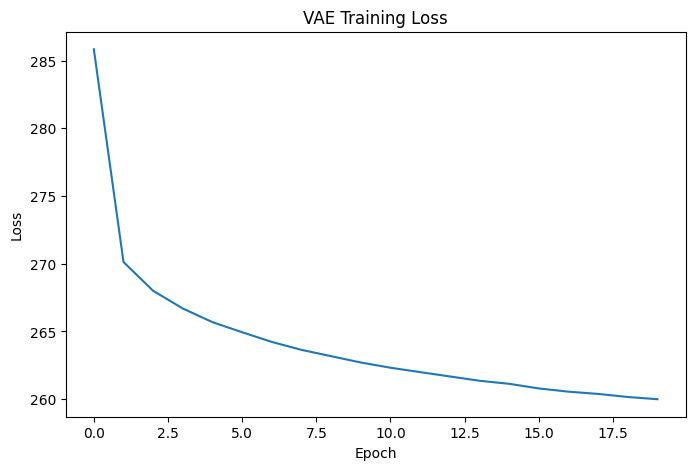

In [4]:
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()
train_losses = []

print("Starting Training...")
for epoch in range(EPOCHS):
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)

        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f}")

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


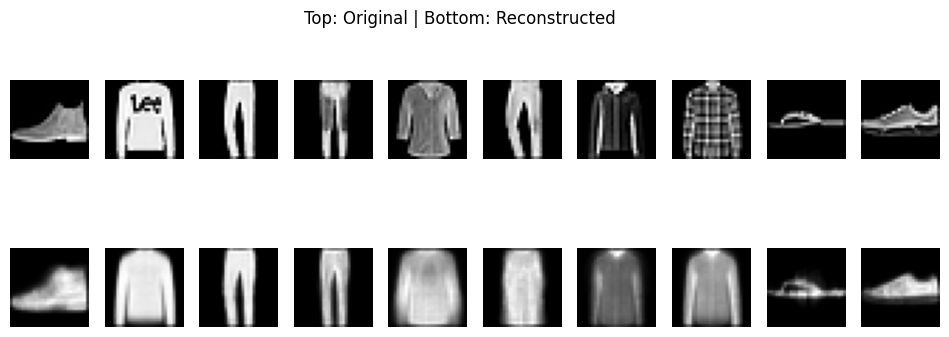

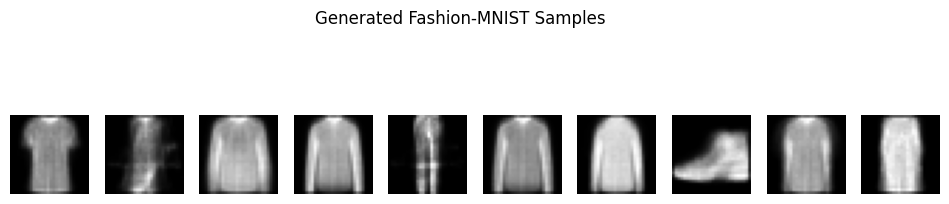

In [5]:
model.eval()

# -------- Reconstruction --------
data, _ = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    recon, _, _ = model(data)

plt.figure(figsize=(12,4))
for i in range(10):
    # Original
    plt.subplot(2,10,i+1)
    plt.imshow(data[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2,10,i+11)
    plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()

# -------- Generate New Samples --------
with torch.no_grad():
    z = torch.randn(10, LATENT_DIM).to(device)
    generated = model.decode(z).cpu().view(10, 28, 28)

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')

plt.suptitle("Generated Fashion-MNIST Samples")
plt.show()


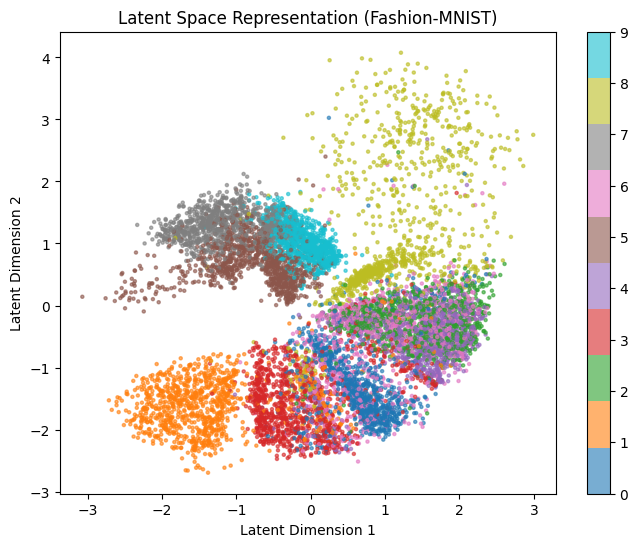

In [6]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 784))
        latent_vectors.append(mu.cpu())
        labels_list.append(labels)

latent_vectors = torch.cat(latent_vectors).numpy()
labels_list = torch.cat(labels_list).numpy()

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    latent_vectors[:,0],
    latent_vectors[:,1],
    c=labels_list,
    cmap='tab10',
    s=5,
    alpha=0.6
)
plt.colorbar(scatter)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation (Fashion-MNIST)")
plt.show()


Using device: cuda

--- Starting Training: KLD DISABLED ---
Epoch 1/10 | BCE Loss: 275.41
Epoch 2/10 | BCE Loss: 261.31
Epoch 3/10 | BCE Loss: 258.55
Epoch 4/10 | BCE Loss: 257.06
Epoch 5/10 | BCE Loss: 256.10
Epoch 6/10 | BCE Loss: 255.43
Epoch 7/10 | BCE Loss: 254.84
Epoch 8/10 | BCE Loss: 254.40
Epoch 9/10 | BCE Loss: 253.95
Epoch 10/10 | BCE Loss: 253.58

--- Starting Training: KLD ENABLED ---
Epoch 1/10 | BCE Loss: 279.36
Epoch 2/10 | BCE Loss: 265.07
Epoch 3/10 | BCE Loss: 262.23
Epoch 4/10 | BCE Loss: 260.33
Epoch 5/10 | BCE Loss: 259.01
Epoch 6/10 | BCE Loss: 258.08
Epoch 7/10 | BCE Loss: 257.29
Epoch 8/10 | BCE Loss: 256.65
Epoch 9/10 | BCE Loss: 256.15
Epoch 10/10 | BCE Loss: 255.68


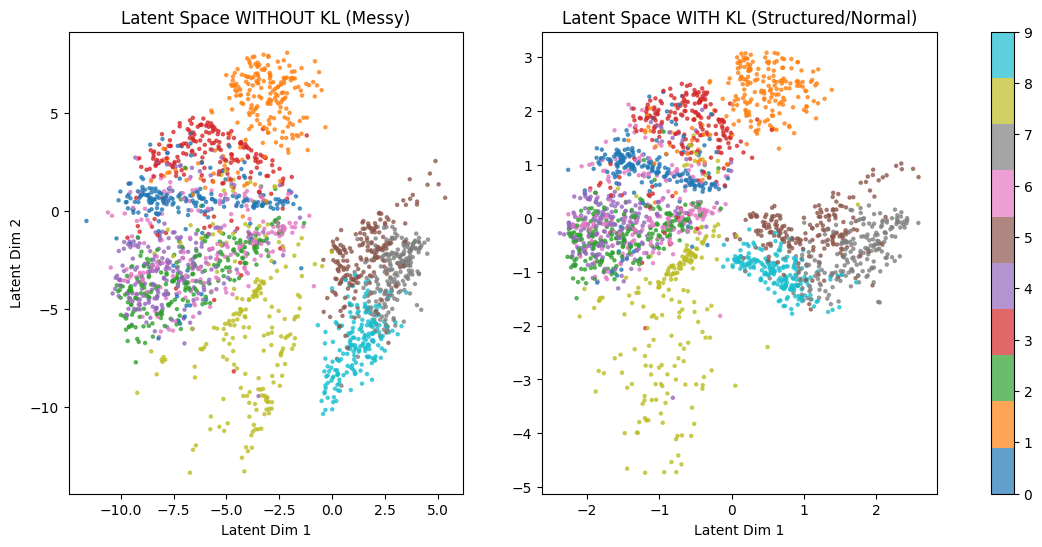

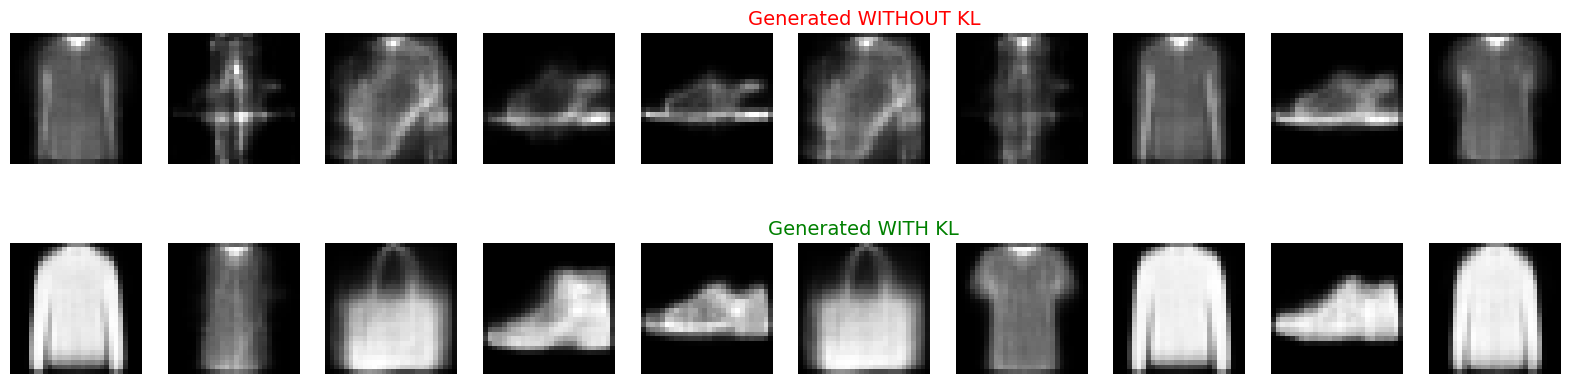

Final BCE Loss (Without KL): 253.58 (Focuses only on memorization)
Final BCE Loss (With KL):    255.68 (Slightly higher tradeoff for valid generation)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# HPC Optimization: Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Dataset Preparation [cite: 20-23] ---
BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor()])

# Download Fashion-MNIST [cite: 46]
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. VAE Architecture [cite: 24-28] ---
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 3. Training Function (Toggle KLD on/off) ---
def train_experiment(use_kld=True, epochs=10):
    model = VAE(latent_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    bce_history = []

    print(f"\n--- Starting Training: KLD {'ENABLED' if use_kld else 'DISABLED'} ---")

    for epoch in range(epochs):
        total_bce = 0
        model.train()
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)

            # Reconstruction Loss (Cross Entropy) [cite: 30]
            BCE = nn.functional.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')

            # KL Divergence [cite: 31]
            if use_kld:
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            else:
                KLD = torch.tensor(0.0).to(device) # Disable KLD

            loss = BCE + KLD
            loss.backward()
            optimizer.step()

            total_bce += BCE.item()

        avg_bce = total_bce / len(train_loader.dataset)
        bce_history.append(avg_bce)
        print(f"Epoch {epoch+1}/{epochs} | BCE Loss: {avg_bce:.2f}")

    return model, bce_history

# --- Run Both Experiments ---
# 1. Without KL (Standard Autoencoder behavior)
model_no_kl, loss_no_kl = train_experiment(use_kld=False, epochs=10)

# 2. With KL (VAE behavior)
model_with_kl, loss_with_kl = train_experiment(use_kld=True, epochs=10)

# --- 4. Visualization & Comparison [cite: 39-42] ---
def compare_latent_space(model_no_kl, model_with_kl, loader):
    model_no_kl.eval()
    model_with_kl.eval()

    z_no_kl, labels_list = [], []
    z_with_kl = []

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            # Encode data to latent space
            mu_no, _ = model_no_kl.encode(data.view(-1, 784))
            mu_with, _ = model_with_kl.encode(data.view(-1, 784))

            z_no_kl.append(mu_no.cpu())
            z_with_kl.append(mu_with.cpu())
            labels_list.append(labels)

            if len(z_no_kl) * BATCH_SIZE > 2000: break # Only plot 2000 points

    z_no_kl = torch.cat(z_no_kl).numpy()
    z_with_kl = torch.cat(z_with_kl).numpy()
    labels = torch.cat(labels_list).numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot No KL
    scatter1 = axes[0].scatter(z_no_kl[:, 0], z_no_kl[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    axes[0].set_title("Latent Space WITHOUT KL (Messy)")
    axes[0].set_xlabel("Latent Dim 1")
    axes[0].set_ylabel("Latent Dim 2")

    # Plot With KL
    scatter2 = axes[1].scatter(z_with_kl[:, 0], z_with_kl[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    axes[1].set_title("Latent Space WITH KL (Structured/Normal)")
    axes[1].set_xlabel("Latent Dim 1")

    plt.colorbar(scatter2, ax=axes.ravel().tolist())
    plt.show()

def compare_generation(model_no_kl, model_with_kl):
    # Generate from pure noise (Standard Normal)
    z = torch.randn(10, 2).to(device)

    with torch.no_grad():
        gen_no_kl = model_no_kl.decode(z).cpu().view(10, 28, 28)
        gen_with_kl = model_with_kl.decode(z).cpu().view(10, 28, 28)

    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    for i in range(10):
        # No KL Generation (Usually Garbage)
        axes[0, i].imshow(gen_no_kl[i], cmap='gray')
        axes[0, i].axis('off')
        if i == 5: axes[0, i].set_title("Generated WITHOUT KL", fontsize=14, color='red')

        # With KL Generation (Valid Clothes)
        axes[1, i].imshow(gen_with_kl[i], cmap='gray')
        axes[1, i].axis('off')
        if i == 5: axes[1, i].set_title("Generated WITH KL", fontsize=14, color='green')

    plt.show()

# Execute comparisons
compare_latent_space(model_no_kl, model_with_kl, test_loader)
compare_generation(model_no_kl, model_with_kl)

# Print Final Loss Comparison
print(f"Final BCE Loss (Without KL): {loss_no_kl[-1]:.2f} (Focuses only on memorization)")
print(f"Final BCE Loss (With KL):    {loss_with_kl[-1]:.2f} (Slightly higher tradeoff for valid generation)")
